### 1D Convnet on IMDB Data

In [1]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
max_len = 500

print('loading data')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

print('Pad Sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train.shape:', x_train.shape)
print('x_test.shape:', x_test.shape)

Using TensorFlow backend.


loading data
Pad Sequences (samples x time)
('x_train.shape:', (25000, 500))
('x_test.shape:', (25000, 500))


In [2]:
%matplotlib inline

from keras import models
from keras import layers
from keras.optimizers import RMSprop

from util import print_curves


def plot_model_jupyter(model):
    SVG(model_to_dot(model).create(prog='dot', format='svg'))


model = models.Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 14, activation='relu'))
# default pool size 2
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()
plot_model_jupyter(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 85, 32)            14368     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,323,105
Trainable params: 1,323,105
Non-trainable params: 0
_________________________________________________________________


In [3]:
plot_model_jupyter(model)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 83s 4ms/step - loss: 0.4853 - acc: 0.7515 - val_loss: 0.3445 - val_acc: 0.8546
Epoch 2/10
20000/20000 [==============================] - 84s 4ms/step - loss: 0.2563 - acc: 0.8962 - val_loss: 0.2853 - val_acc: 0.8836
Epoch 3/10
20000/20000 [==============================] - 84s 4ms/step - loss: 0.1865 - acc: 0.9284 - val_loss: 0.3126 - val_acc: 0.8734
Epoch 4/10
20000/20000 [==============================] - 84s 4ms/step - loss: 0.1413 - acc: 0.9475 - val_loss: 0.3522 - val_acc: 0.8670
Epoch 5/10
20000/20000 [==============================] - 83s 4ms/step - loss: 0.1001 - acc: 0.9661 - val_loss: 0.3639 - val_acc: 0.8756
Epoch 6/10
20000/20000 [==============================] - 83s 4ms/step - loss: 0.0657 - acc: 0.9793 - val_loss: 0.4017 - val_acc: 0.8734
Epoch 7/10
20000/20000 [==============================] - 83s 4ms/step - loss: 0.0409 - acc: 0.9883 - val_loss: 0.4493 - val_acc:

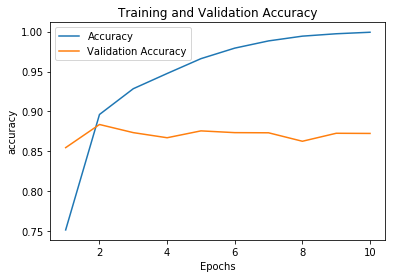

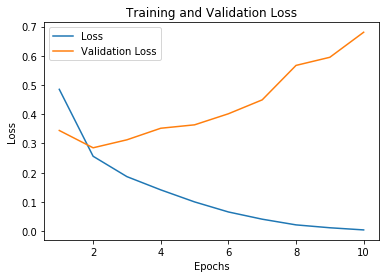

In [22]:
model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

print_curves(history)

In [28]:
plot_model_jupyter(model)

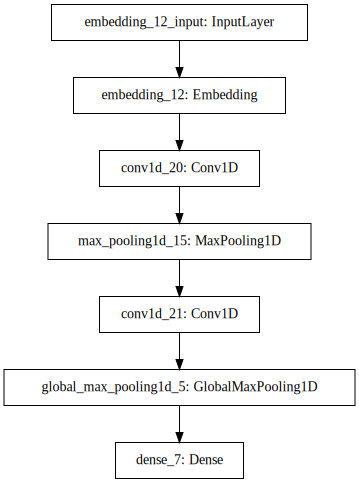

In [27]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [26]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot